In [213]:

!pip install opendatasets
!pip install category_encoders
import opendatasets as od
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#About Dataset
Explore the salaries of higher education employees from Ohio's public universities dating back to 2011.

This dataset offers insights into the earnings of various positions across multiple institutions. Please note that benefits are not included in the reported salaries.

In [214]:
datasetlink = "https://www.kaggle.com/datasets/asaniczka/university-employee-salaries-2011-present"
od.download(datasetlink)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kidkeozz
Your Kaggle Key: ··········


100%|██████████| 17.5M/17.5M [00:01<00:00, 17.4MB/s]


In [215]:
os.chdir("university-employee-salaries-2011-present")
os.listdir()

['higher_ed_employee_salaries.csv']

In [216]:
archivo = 'higher_ed_employee_salaries.csv'
df = pd.read_csv(archivo)
df.head(10)

,Name,School,Job Description,Department,Earnings,Year
0,Don Potter,University of Akron,Assistant Lecturer,Social Work,2472.00,2019
1,Emily Potter,The Ohio State University,Administrative Assistant 3,Arts and Sciences | Chemistry and Biochemistry...,48538.02,2022
2,Carol Jean Potter,The Ohio State University,Associate Professor-Clinical,Pediatrics,22722.80,2013
3,Kim Potter,The Ohio State University,"Manager 4, Compliance",Legal Affairs | Compliance,170143.44,2022
4,Graham Potter,Miami University,Building and Grounds Assistant,"Assoc VP Housing,Dining,Rec,Bus Svc",3075.20,2012
5,Amanda Potter,The Ohio State University,Program Coordinator,WCA-Education,48806.72,2013
6,Susan Marie Potter,The Ohio State University,Program Manager,College of Nursing,65216.00,2013
7,Katrina Potter,Miami University,Personnel Technician,VP for Acad Affrs-Provost,24324.14,2012
8,Pamela Lynn Potter,Bowling Green State University,Administrative Assistant 2,Center for Teaching & Learning,51496.58,2012
9,Kimberly J Potter,The Ohio State University,Policy Anlyst/Compliance Offcr,Legal Affairs Administration,20868.00,2015


In [217]:
df.shape

(934348, 6)

In [218]:
df = df.drop_duplicates()

In [219]:
df.shape

(801136, 6)

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801136 entries, 0 to 934347
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             801136 non-null  object 
 1   School           801136 non-null  object 
 2   Job Description  778573 non-null  object 
 3   Department       750021 non-null  object 
 4   Earnings         792807 non-null  float64
 5   Year             801136 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 42.8+ MB


In [221]:
df['Earnings'] = df['Earnings'].round(0)

In [222]:
df.sample(5)

,Name,School,Job Description,Department,Earnings,Year
382163,David Evans,University of Akron,Assistant Lecturer,Disaster Science & Emerg Svs,2318.0,2018
155538,Joseph A. Belinsky,Kent State University,Outreach Program Coord,"Dean, Tuscarawas Campus",40090.0,2013
851076,Priyusha Pokala,Kent State University,Faculty Part-Time -Semester,Biological Sciences,3450.0,2017
403561,Rustina L Lewis,The Ohio State University,Early Childhood Teaching Ast 1,Child Care Program,5262.0,2015
393093,Susan E. Goehring,Kent State University,Sponsored Prog Administrator,Research & Sponsored Programs,45632.0,2020


In [223]:
df.isnull().sum()

Name                   0
School                 0
Job Description    22563
Department         51115
Earnings            8329
Year                   0
dtype: int64

In [224]:
df = df[~df['Earnings'].isnull()]
df = df[df['Earnings'] >=10000]

P = np.percentile(df['Earnings'], [1, 99])
df = df[(df['Earnings'] > P[0]) & (df['Earnings'] < P[1])]

In [225]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Earnings,640434.0,62465.460243,41672.403466,10916.0,35000.0,52500.0,77818.0,299655.0
Year,640434.0,2017.163380,3.173586,2011.0,2015.0,2017.0,2020.0,2022.0


In [226]:
df.isnull().sum()

Name                   0
School                 0
Job Description    15340
Department         44664
Earnings               0
Year                   0
dtype: int64

In [227]:
print('# of departments {}'.format(len(df['Department'].unique())))

# of departments 8842


In [228]:
df['Department'].value_counts().head(10)

Department
University Hospitals              33363
Cancer Hosp & Research Instit     25196
University                        17387
Health System                     14944
Shared Services                   10179
University Hospitals East          8586
Internal Medicine                  7131
Ross Heart Hospital                6273
Comprehensive Cancer Center RU     4716
Pediatrics                         4104
Name: count, dtype: int64

In [229]:
print('# of jobs {}'.format(len(df['Job Description'].unique())))

# of jobs 34853


In [230]:
df['Job Description'].value_counts().head(10)

Job Description
Professor                       23528
Associate Professor             21128
Assistant Professor             15611
Staff Nurse-B                   15171
Clinical Inst HS                 9519
Lecturer                         7945
Custodial Worker                 7579
Patient Care Associate           6983
Assistant Professor-Clinical     5838
Staff Nurse                      5334
Name: count, dtype: int64

In [231]:
df = df[~df['Department'].isnull()]
df = df[~df['Job Description'].isnull()]

In [232]:
df.isnull().sum()

Name               0
School             0
Job Description    0
Department         0
Earnings           0
Year               0
dtype: int64

In [233]:
df['Name'] = df['Name'].apply(lambda x: x.split()[0])
df.sample(5)

,Name,School,Job Description,Department,Earnings,Year
785963,John,The Ohio State University,Mgr-Traffic Control & Events,University,61620.0,2021
429553,Kayla,University of Toledo,1st Asst Softball Coach,Softball,20087.0,2022
199286,Zeina,The Ohio State University,Staff Nurse-A (HS),"University Hospital | 4 Dodd Hall, General and...",60763.0,2022
794410,Kriti,The Ohio State University,SR Systms Dev/Eng-Not Sap,OCIO Operations,54848.0,2017
314516,Jorge,University of Toledo,Assoc Prof/Chief Surg Transplt,Surgery,103510.0,2016


In [234]:
top_10_jobs=df.groupby("Job Description")['Earnings'].mean().reset_index(name='salary mean').sort_values(by='salary mean', ascending=False).head(10)
top_10_jobs

,Job Description,salary mean
29247,VP for U Advancement,299129.0
17425,Int VP D&I/Dean Coll Arts&Ltrs,298335.0
22870,"Prof Pract, Accountancy",298267.0
23821,Provost & Sr VP Acad Affairs,297639.0
14922,"Exec VP, CPM",297600.0
27214,"Sr VP, Strat Comm & Ext Affair",297279.0
10771,"Dean, College Of Business",297212.5
95,ARMCO Alumni Assoc Professor,296836.0
8424,Chief Operating Officer - UTMC,296585.0
10809,"Dean, Russ College Of Engineering And Technology",295000.0


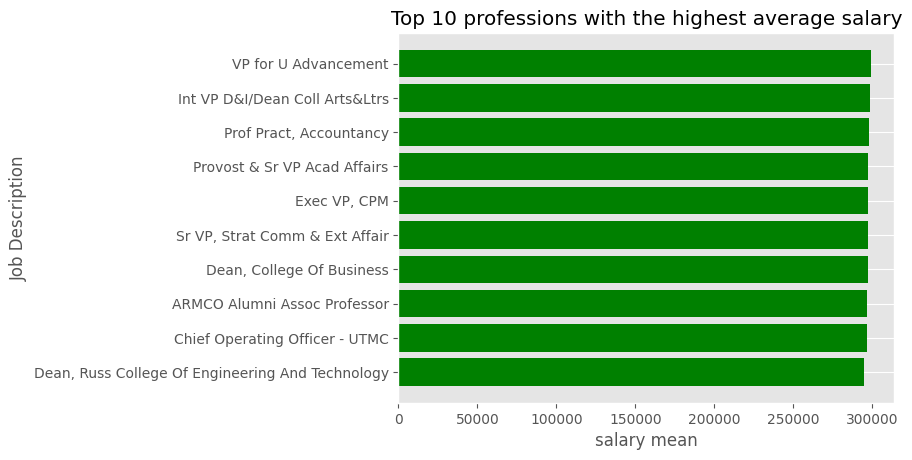

In [235]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.barh(top_10_jobs['Job Description'],top_10_jobs['salary mean'],color='green' )
ax.set_title('Top 10 professions with the highest average salary')
ax.set_xlabel('salary mean')
ax.set_ylabel('Job Description')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [236]:
top_10_depar=df.groupby("Department")['Earnings'].mean().reset_index(name='salary mean').sort_values(by='salary mean', ascending=False).head(10)
top_10_depar

,Department,salary mean
8485,VP for Legal Affairs and General Counsel,292875.000000
4750,Human Resources | Shared Services,281873.000000
593,Academic Affairs Administration | External Eng...,274332.000000
5761,Medicine | Internal Medicine Infectious Disease,264155.333333
2133,COM Pediatrics,248897.500000
4060,FGP-Radiology,235470.000000
3802,Executive VP to the President,230000.000000
4061,FGP-Spine/Neuro,229527.400000
595,Academic Affairs Administration | Inclusive Ex...,220189.000000
5753,Medicine | IM Hospital Medicine,217040.410448


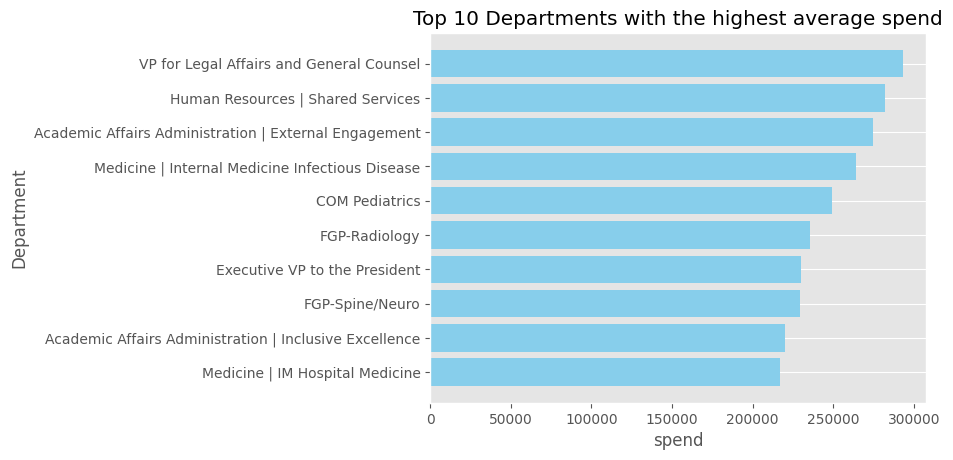

In [237]:
fig, ax = plt.subplots()
ax.barh(top_10_depar['Department'],top_10_depar['salary mean'],color='skyblue' )
ax.set_title('Top 10 Departments with the highest average spend')
ax.set_xlabel('spend')
ax.set_ylabel('Department')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [238]:
total_spend=df.groupby("School")['Earnings'].sum().reset_index(name='total spend').sort_values(by='total spend', ascending=False).head(13)
total_spend

,School,total spend
7,The Ohio State University,1.956968e+10
10,University of Toledo,3.439272e+09
3,Kent State University,2.558717e+09
4,Miami University,2.059267e+09
5,Ohio University,1.983306e+09
11,Wright State University,1.673851e+09
8,University Of Cincinnati,1.653196e+09
0,Bowling Green State University,1.368302e+09
12,Youngstown State University,7.208942e+08
2,Cleveland State University,7.133161e+08


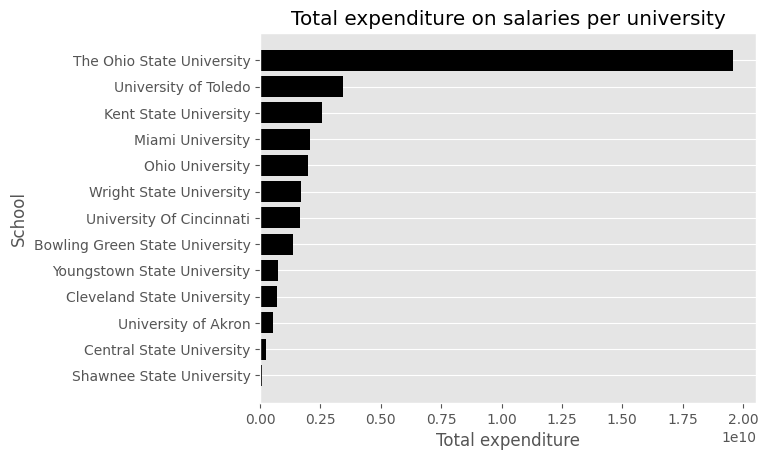

In [239]:
fig, ax = plt.subplots()
ax.barh(total_spend['School'],total_spend['total spend'],color='black' )
ax.set_title('Total expenditure on salaries per university')
ax.set_xlabel('Total expenditure')
ax.set_ylabel('School')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [241]:
dfp = df.copy()

job_counts = dfp['Job Description'].value_counts()
mask = (job_counts < 10).values
jobs_to_replace = job_counts[mask].index
dfp['Job Description'] = dfp['Job Description'].apply(lambda x: 'other' if x in jobs_to_replace else x)


depar_count = dfp['Department'].value_counts()
mask = (depar_count < 10).values
depar_to_replace = depar_count[mask].index
dfp['Department'] = dfp['Department'].apply(lambda x: 'other' if x in jobs_to_replace else x)


print('Unique jobs: {}'.format(len(dfp['Job Description'].unique())))
print('Unique Departments: {}'.format(len(dfp['Department'].unique())))

Unique jobs: 4756
Unique Departments: 8635


In [242]:
lb_encoder = LabelEncoder()
dfp['School']=lb_encoder.fit_transform(dfp['School'])

encoder = ce.BinaryEncoder(cols=['Job Description','Department' ])
df_encoded = encoder.fit_transform(dfp)

df_encoded.sample(5)

,Name,School,Job Description_0,Job Description_1,Job Description_2,Job Description_3,Job Description_4,Job Description_5,Job Description_6,Job Description_7,...,Department_6,Department_7,Department_8,Department_9,Department_10,Department_11,Department_12,Department_13,Earnings,Year
682402,Vaishavi,7,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,26111.0,2022
314929,Annie,7,0,0,0,1,1,1,0,1,...,1,1,1,1,0,1,1,1,54020.0,2022
68927,Christine,8,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,56297.0,2011
412599,Thomas,7,0,0,0,0,0,1,1,0,...,1,1,0,0,1,0,1,1,152744.0,2020
590590,Laura,7,0,0,0,1,0,1,0,0,...,1,0,0,1,0,0,1,1,16848.0,2022


In [244]:
X = df_encoded.drop(columns=['Earnings', 'Name'])
y = df_encoded['Earnings']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=24, test_size=0.4)

In [245]:
estimator = xgb.XGBRegressor()
Params_grid = {
    'num_boost_round': [30,50,100,150],
    'max_depth': [1,2],
    'colsample_bytree':[0.7,1],
    'eta':[0.01,0.1],
    'samples':[0.5,0.8]
}

grid_mse = GridSearchCV(estimator = estimator, param_grid=Params_grid, scoring='neg_mean_squared_error',verbose=1, cv=3)
grid_mse.fit(X_train,y_train)

print(f'best params {grid_mse.best_params_}')
print(f'best score {(-grid_mse.best_score_)**0.5}')

Fitting 3 folds for each of 64 candidates, totalling 192 fits
best params {'colsample_bytree': 0.7, 'eta': 0.1, 'max_depth': 2, 'num_boost_round': 30, 'samples': 0.5}
best score 39328.748263877744


In [246]:
best_model = grid_mse.best_estimator_
pred = best_model.predict(X_test)


best_score = mean_squared_error(y_test, pred)**0.5
print(f'XGBRegressor RMSE : {best_score}')

XGBRegressor RMSE : 39584.30556023612


In [247]:
dmatrix = xgb.DMatrix(data = X, label = y)


params = {'colsample_bytree': 1, 'eta': 0.1, 'max_depth': 2, 'objective':'reg:linear', 'samples': 0.5}
cv_results = xgb.cv(dtrain=dmatrix, params = params, early_stopping_rounds=10, num_boost_round=50, nfold=3, metrics='rmse', as_pandas=True, seed=12)


print('Tuned rmse %f' %((cv_results['test-rmse-mean']).tail(1)))

Tuned rmse 39764.233292
